# Random forest

In this lab, we will be using the `RandomForestRegressor` class from `sklearn.ensemble` to train and tune a random forest regression model on the `Concrete` dataset. The corresponding class for classification is `RandomForestClassifier`.

There are a few differences from the `randomForest` package in R:

1. `RandomForestRegressor` and `RandomForestClassifier` do not directly support categorical features. These need to be one-hot encoded. 
2. The importance measures reported are impurity reduction based measures. They do not support calculating permutation based feature importance metrics using out-of-bag (OOB) data. 


**Equivalent hyperparameters:**

| scikit-learn     | randomForest |
|:-----------------|:-------------|
| n_estimators     | ntree        |
| max_features     | mtry         |
| min_samples_leaf | nodesize     |
| max_leaf_nodes   | maxnodes     |

The scikit-learn versions also have an additional hyperparameter - `max_depth`, which controls the maximum depth of the tree. The maximum number of leaves will be $2^\mathrm{max\_depth}$.

In [1]:
## load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")

# extract the predictors - no need for standardization
X = crt.drop('Strength',axis=1).values # extract as numpy ndarray
X_col_names = crt.drop('Strength',axis=1).columns.tolist() # store column names as list

# standardize response - to keep things consistent with gradient boosting 
y = crt['Strength'].values
y_mean,y_std = y.mean(),y.std()
y = (y-y_mean)/y_std

## Training and prediction interface

The API is very similar to other scikit-learn estimators.

In [4]:
reg_init = RandomForestRegressor(
    n_estimators = 500,
    min_samples_leaf = 5,
    oob_score=True
)

# fit model
reg0 = clone(reg_init).fit(X,y)

# computing predictions on training set
y_pred = reg0.predict(X)
# residuals
e = y-y_pred

# training metrics
training_r2 = 1 - np.mean(e**2)/y.var()
print('Training R2: %5.3f'%training_r2)

Training R2: 0.947


Random forests can provide a different estimate for generalization performance - the out-of-bag (OOB) score/loss. To enable this, we need to pass `oob_score=True` in the constructor (or in the `.set_params` method before fitting the model). **While K-fold CV is a better estimate of generalization performance** (particularly in terms of precision), OOB metrics are much faster to compute.

**Note**: Do NOT use the OOB score as a proxy for cross-validation, when comparing with other models.

In [5]:
# Out-of-bag predictions for the training observations
y_pred_oob = reg0.oob_prediction_

# OOB R2
print('OOB R2: %5.3f'%reg0.oob_score_)

OOB R2: 0.893


## Tuning the number of trees while training.

The `randomForest` library in R has an API for plotting the OOB error vs the number of trees. This allows us to pick a suitable value for the number of trees at which the OOB error stabilizes. We can do something similar in scikit-learn, although the steps are slighthly more involved. Note that producing this plot requires fitting the trees in sequence. 

In [6]:
np.random.seed(1234)

regr = RandomForestRegressor(
    min_samples_leaf = 5,
    oob_score=True,
    warm_start=True # setting this to True allows us to add more trees sequentially
)

# Range to explore
min_estimators = 15
max_estimators = 500

# list to store the OOB errors
oob_error_rate = []

for i in range(min_estimators,max_estimators+1,5):
    # fit 5 additional trees every iteration
    regr.set_params(n_estimators=i)
    regr.fit(X,y)
    
    # store the oob error
    oob_error = 1-regr.oob_score_
    oob_error_rate.append((i,oob_error))

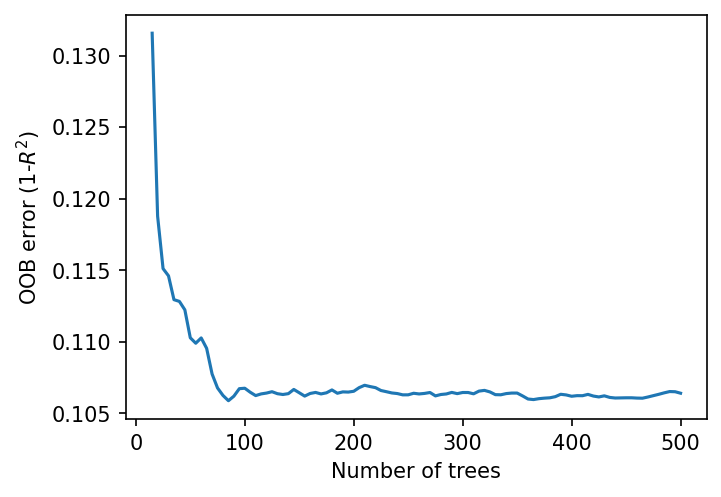

In [7]:
fig,ax = plt.subplots(1,1,figsize=(5,3.5))

n_trees, oob_errors = zip(*oob_error_rate)
_ = ax.plot(n_trees,oob_errors)
_ = ax.set_xlabel('Number of trees')
_ = ax.set_ylabel('OOB error (1-$R^2$)')

**Note**: The plot can have a different profile if we used a different seed. OOB measures are noisy.

## Hyperparameter tuning 

1. Unlike in gradient boosting, increasing the number of trees in random forests does not affect the generalization performance. We only need to ensure that we have a sufficient number of trees. So, `n_estimators` is not a particularly important hyperparameter. We will use `n_estimators=500`.
2. The most important hyperparameter is `max_features` - the number of features to consider as candidates at each split. A smaller `max_features` injects more randomness into the individual trees, causing them to be less correlated, and therefore can counter overfitting.
3. We can adjust individual tree complexity by specifing `min_samples_leaf`, and one of `max_leaf_nodes` or `max_depth` - the model might overfit if the individual trees are too deep. We will tune `max_depth` here. 


We will be using the `hyperopt` library for tuning the hyperparameters. There are two objectives for tuning - the OOB error or the usual CV error. The OOB method is faster but the computed metric is less accurate and has more noise than the CV metric. We will use the default OOB error here, and leave the CV optimization objective as an exercise.

In [8]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope


from typing import Dict

In [18]:
# STEP 1: define search space
search_space = {
    'max_features': scope.int(hp.quniform('max_features',2,X.shape[1],1)),
    'max_depth': scope.int(hp.quniform('max_depth',4,9,1)), 
    'min_samples_leaf':scope.int(hp.quniform('min_samples_leaf',2,50,1)),
}

# STEP 2: define the objective

def rf_oob_error(params:Dict) -> Dict:
    # train model
    model = (
        RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=3)
        .set_params(**params) # set the hyperparameters
        .fit(X,y)
    )
    
    # return oob error: 1-R^2
    return {'loss':1-model.oob_score_,'status':STATUS_OK}


# STEP 3: run hyperopt
np.random.seed(123)
trials = Trials() # maintains an optimization history
best = fmin(
    rf_oob_error, # loss function
    search_space, # search space
    algo=tpe.suggest,
    max_evals = 30, # number of hyperparameter configurations to explore
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|██████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38trial/s, best loss: 0.0971276073248506]


{'max_depth': 9, 'max_features': 4, 'min_samples_leaf': 3}

In [19]:
# gather all results
results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['error_oob'] = [tmp['loss'] for tmp in trials.results]
results['R2_oob'] = 1-results['error_oob']

results.sort_values('R2_oob',ascending=False).head(10)

,max_depth,max_features,min_samples_leaf,error_oob,R2_oob
22,9,4,3,0.097128,0.902872
21,8,8,3,0.103852,0.896148
25,8,3,2,0.107799,0.892201
26,9,4,6,0.117131,0.882869
23,9,2,3,0.128262,0.871738
4,8,6,10,0.132056,0.867944
14,6,7,9,0.145840,0.854160
19,6,5,9,0.147302,0.852698
15,6,6,12,0.154610,0.845390
20,5,8,4,0.166974,0.833026


## Final model 

In [20]:
rf_final = (
    RandomForestRegressor(n_estimators=250,oob_score=True,n_jobs=3)
    .set_params(**best) # set the best hyperparameters
    .fit(X,y)
)

# computing predictions on training set
y_pred = rf_final.predict(X)
# residuals
e = y-y_pred

# training metrics
training_r2 = 1 - np.mean(e**2)/y.var()
print('Training R2: %5.3f'%training_r2)

Training R2: 0.954


We will now compare how well this model performs relative to the other models (that we had fit in Python) using 5-replicates of 5-fold CV.

In [21]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [22]:
np.random.seed(1234)

# 5 replicates of 5-fold CV
n_folds = 5
n_repeats=5
rkf = RepeatedKFold(n_splits=n_folds,n_repeats=n_repeats)
mses_rkf = np.empty(n_folds*n_repeats)


for i,(train_index,test_index) in enumerate(rkf.split(X)):   
    # train RF model on the train split
    reg_fold = (
        RandomForestRegressor(n_estimators=250,oob_score=True,n_jobs=3)
        .set_params(**best) # set the best hyperparameters
        .fit(X[train_index,:],y[train_index])
    )

    # compute test predictions
    
    y_test_pred = reg_fold.predict(X[test_index,:])
    # compute metric-mean-squared error
    mses_rkf[i] = mean_squared_error(y[test_index],y_test_pred)
    
mse_rf_cv = mses_rkf.mean()
r2_rf_cv = 1-mse_rf_cv/y.var()

print('CV R2.....: %5.3f'%r2_rf_cv)

CV R2.....: 0.891


For reference

    CV R2 for neural network.....: 0.914 (tuned using grid search)
    CV R2 for GAM regression.....: 0.885
    CV R2 for regression tree....: 0.797
    CV R2 for linear regression..: 0.605

## Feature importances

Feature importances can be retrieved from the `.feature_importances_` attribute. These are just the average of the feature importance metrics computed by each tree in the ensemble. Note that these are NOT permutation based importance metrics.

In [23]:
feat_imp = rf_final.feature_importances_

# naming the entries using Pandas series
feat_imp_named = pd.Series(feat_imp,index=X_col_names)

# sort in decreasing order of feature importance
feat_imp_named.sort_values(ascending=False).round(4)

Age       0.3475
Cement    0.2822
Water     0.1172
SPlast    0.0762
Slag      0.0646
FAgg      0.0451
CAgg      0.0339
FlyAsh    0.0334
dtype: float64

**Note**: Scikit-learn provides a function for calculation permutation-based importance metrics - `permutation_importance` from the `sklearn.inspection` module. However, unlike in the `randomForest` package in R, this function does not take OOB errors. Instead, it requires a separate validation set. Using the training set instead would provide misleading results. We will skip this function for this lab.

## Partial dependence plots

In [24]:
from sklearn.inspection import PartialDependenceDisplay

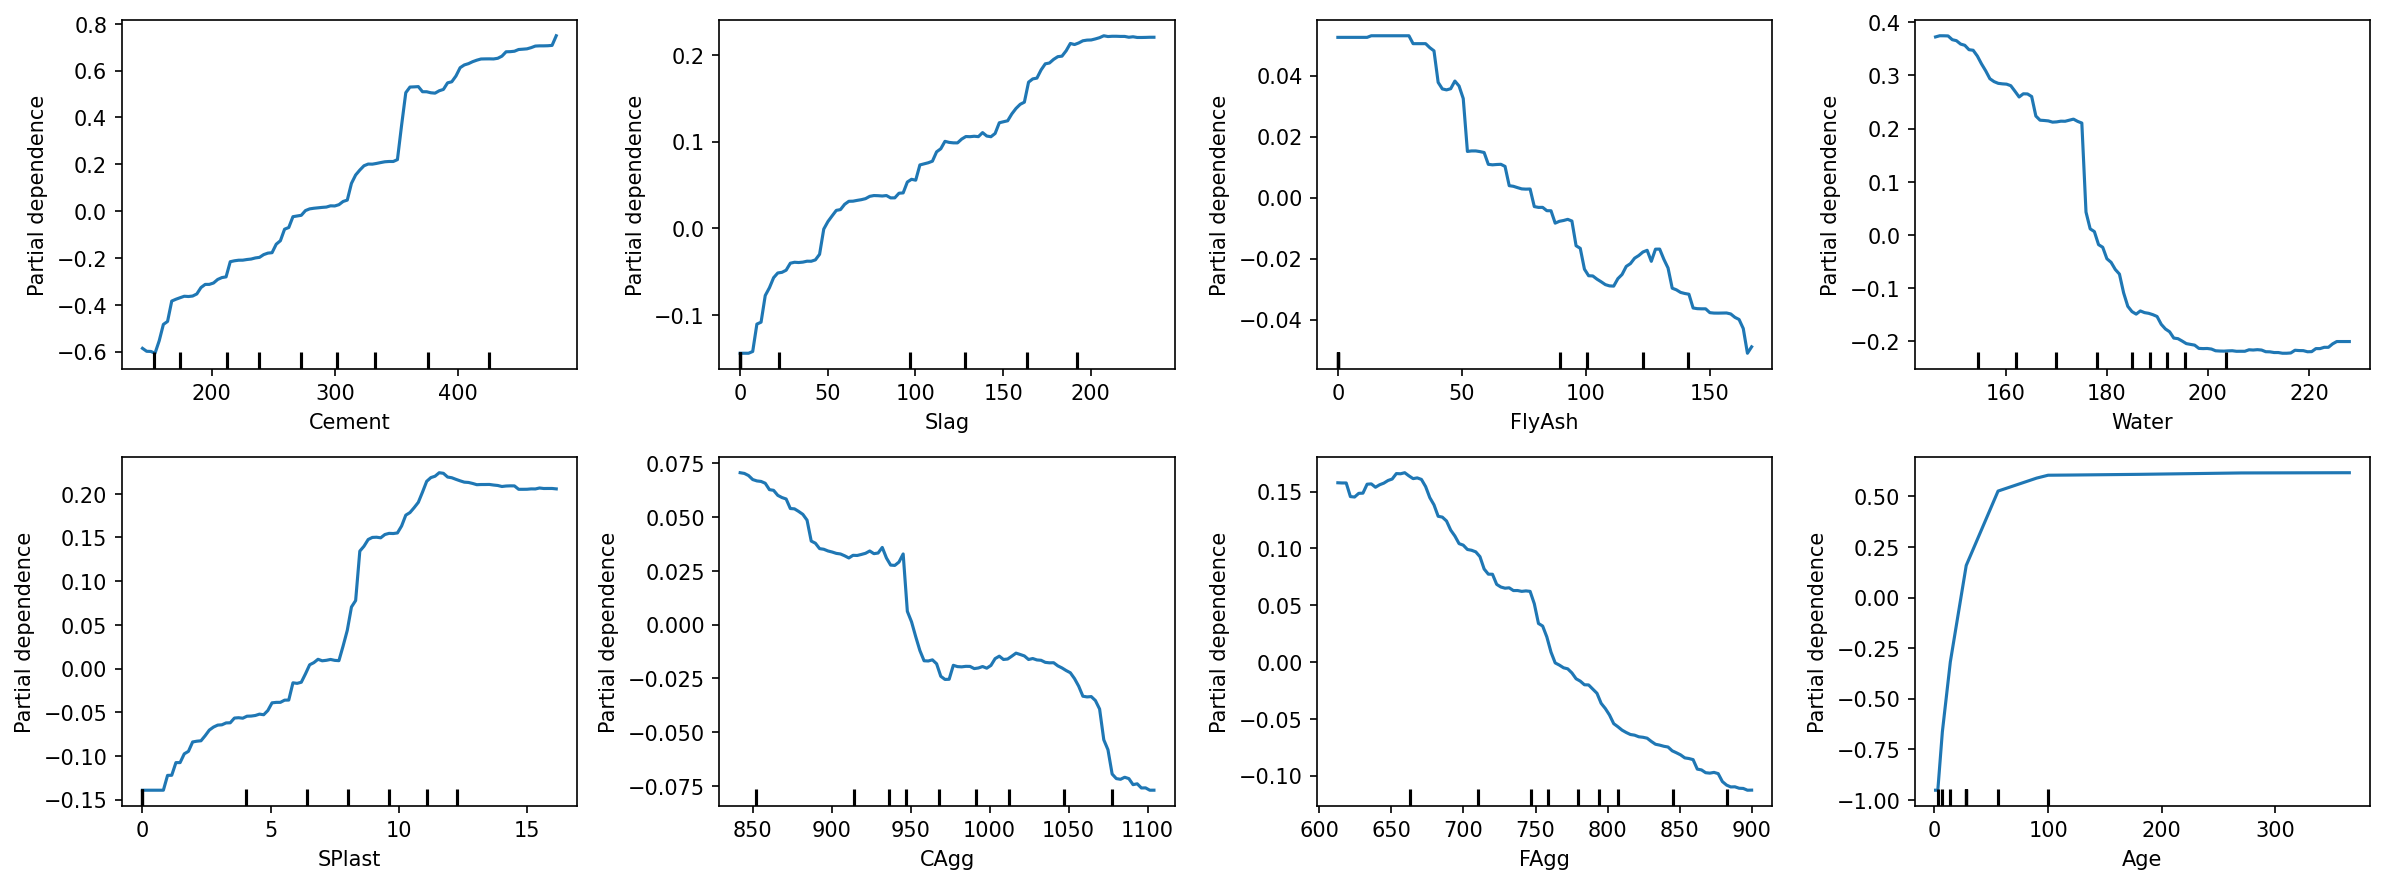

In [25]:
# 1-D Partial dependence plots
num_rows=2
num_cols=4
fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature_idx = num_cols*i+j
        
        _ = PartialDependenceDisplay.from_estimator(
            estimator=rf_final,
            X=X, # training data
            features=[feature_idx],
            feature_names=X_col_names,
            ax=axs[i,j]
        )

fig.tight_layout()

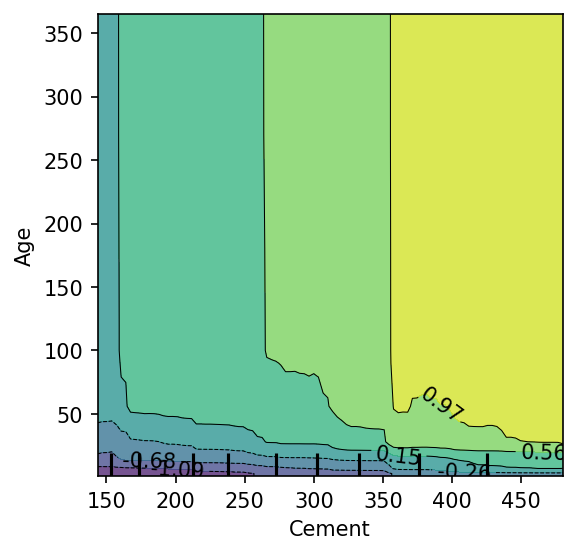

In [26]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
res = PartialDependenceDisplay.from_estimator(
    estimator=rf_final,
    X=X, # training data
    features=[(0,7)], # pass a list of (int,int)
    feature_names=X_col_names,
    ax=ax
)

**Exercise**: Compare the partial dependence plots with the ALEPlots. Refer to the labs in Week 4 for the ALE plot scripts